In [1]:
import numpy as np 
import pandas as pd 
import cv2
import os # used
from xml.etree import ElementTree # import to read/locate xml elemnts 
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras import datasets, layers, models
keras = tf.keras


In [5]:
classes = ['person','person-like'] # text to locate inside the xml person or person like
labeled_class = {class_name:i for i, class_name in enumerate(classes)} # setting up the dict keys person/personlike
# iteriate, save the class labels 'person,person like'

n_classes = 2 
# 2 classes person or person like




size = (75,50)


In [6]:
# create a function to load in data and label the classes person or person like

def load_data():
     # datasets variable list of the 3 folders for train,test and validation
    datasets = ['Train/Train', 'Test/Test', 'Val/Val'] 
    output = []
   
    
    for dataset in datasets:
        
        images = [] # create list
        labels = [] # create list 
        
        # adding the dataset loop to the file path of Annotations(xml files)
        directoryANNOTATE = "Data/Pdata/" + dataset + "/Annotations/" 
        
        # adding the dataset loop to file path of images 
        directoryIMGAGES = "Data/Pdata/" + dataset + "/JPEGImages/" 
        
        # listdir() returns a list containing the names of the entries in the directory given by path, now we can loop it
        file = os.listdir(directoryANNOTATE) 
        jpg = os.listdir(directoryIMGAGES) 
        
        # organizing the annotations files to match the image order so the classes are labeled corrrctly to each image
        file.sort() 
        
        # organizing the images to match the order of the xml so the images are labeled correctly(person,like person)
        jpg.sort() 
        
        
        i = 0
        
        # loop through the xml files(file_) 
        #we need to match and idenify the class of each image by matching it with the annotation xml file
        for xml in file:
            
            # combining the annotations with the xml 
            xmlf = os.path.join(directoryANNOTATE,xml)
            
            # ElementTree represents the whole XML folder as a tree, and Element represents a single node in this tree. 
            dom = ElementTree.parse(xmlf)
            
            # iteriate through the xml annotations files and locate object element
            objct = dom.findall('object')  
            
            # from the object element now locate name element in the xml annotation file and only take the first object
            label_name = objct[0].find('name').text 
            
            # this will append all text either 'person / person like' found in the xml file
            # inside the name element, and saved off to the labeled_class 
            labels.append(labeled_class[label_name]) 
          
            # directory for images and the list of images to loop through
            img_path = directoryIMGAGES + jpg[i] 
            
            # taking rbg color value and assigning to tensor(3 dim matrix) imagedatagen
            curr_img = cv2.imread(img_path)
            
            
            # resize the org image to my custom perference 
            curr_img = cv2.resize(curr_img, size)
            
            
            #append the list of images that have been resized 
            images.append(curr_img) 
           
            
            # +1 to move to the next image after completing loop
            i +=1
            
        # creating a numpy array of tensors, instead of list of tensors
        images = np.array(images, dtype='float32')
        
        
        # normalizing all images so the pixel values are between 0-1(imagedatagen)
        images = images / 255
        
        
        
        
        # tranforming the list of tensor to a numpy array.
        labels = np.array(labels, dtype='int32')
        
        
        # creating the list and joining together the labels and images
        output.append((images, labels)) 
       
    return output

In [13]:
# loading in the data
(train_images, train_labels),(test_images, test_labels),(val_images, val_labels) = load_data()

KeyboardInterrupt: 

In [8]:
# confirm train size
train_images.shape

(944, 200, 200, 3)

In [9]:
# confirm label size matches image size (train_label = annotation xml files with class indication person or person_like)
train_labels.shape

(944,)

In [10]:
val_images.shape

(160, 200, 200, 3)

In [11]:
test_images.shape

(235, 200, 200, 3)

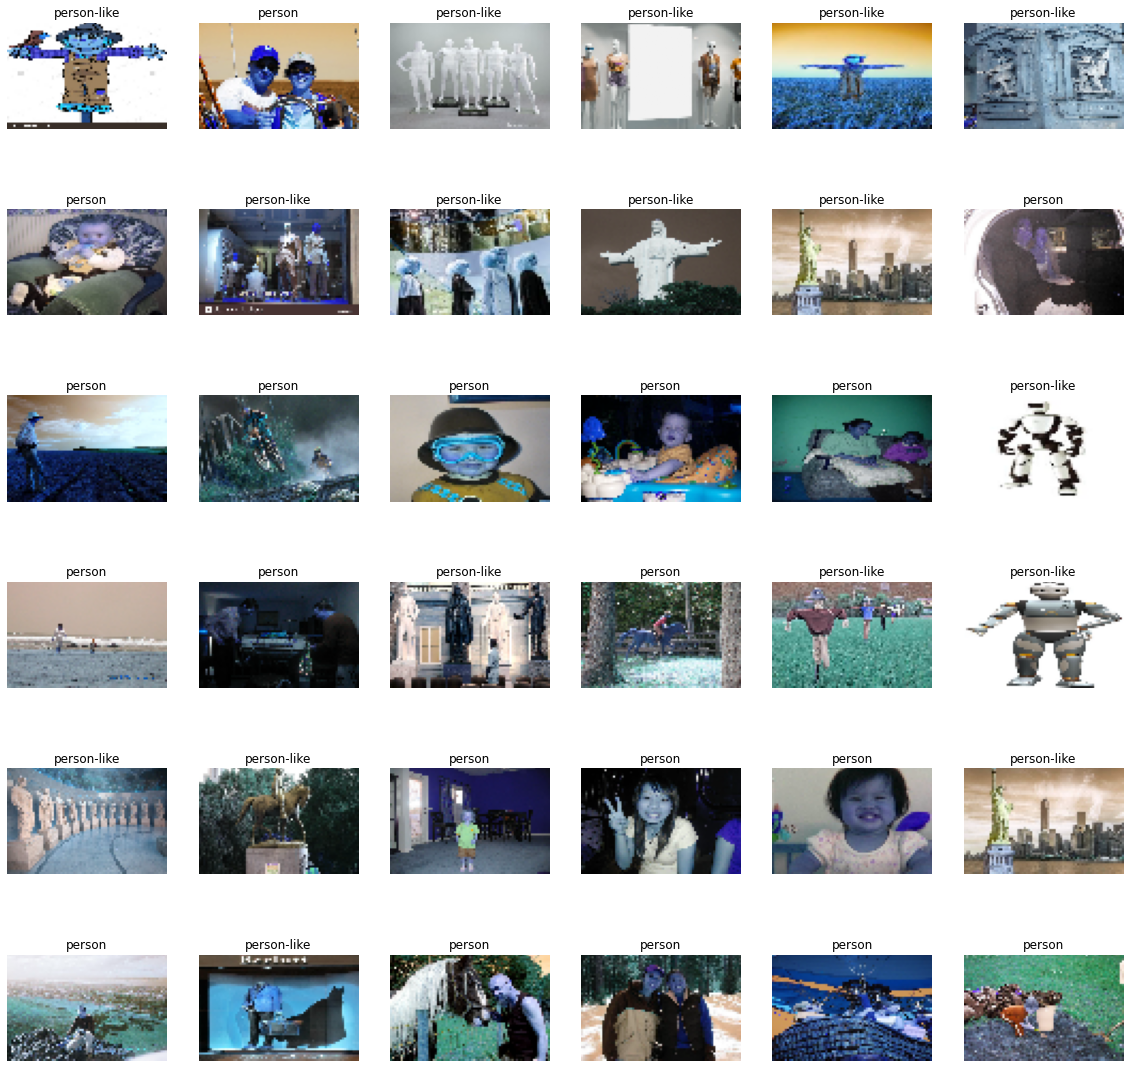

In [41]:
# looking at rabdom images from training data
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(train_images),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(train_images[i])  
    plt.title(classes[train_labels[i]])
    plt.axis('off')

In [42]:
#Conv2d hyperparameter layout ( filter= learns how to detect features in the image to declare the class 
#                Kernel= the size of the filter/matrix as it transform the image 
#                strides= how many vectors the kernel moves across the matrix 
#                padding=analyzes the image to the edge/corner and beyond by 1 vector to optimize the analysis
#                activation = takes the output from pervious layer and passes it to the next layer(transforming the signal based on the function type)
#                input= pixel shape of image(200,200 matrix) and last digit in this case 3 = rgb(color image scale)
#                3 values combined in a single pixel will represent the final color the pixel displays
#                red value = 0, blue= 255, green= 255 this combination will result in yellow
#                255 is the brightest and highest value, will 1 being most faint, zero results as nonpresent  )

# Flatten

# RMSProp with momentum generates its parameter updates using a momentum on the rescaled gradient,
# binary model only two classes
# specifically optimizing tp & fp want to detect all images correctly 


In [44]:
# create CNN model first model 
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(5,5),strides=(1, 1),padding='same', activation='relu', input_shape=(50, 75, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=96, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=108, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])# specifically optimizing tp & fp want to detect all images correctly 


#saving off the model as an object for predicts etc...
history = model.fit(train_images, train_labels, epochs=30, batch_size=32,
                    validation_data=(val_images, val_labels))

Epoch 1/30
30/30 [==============================] - 12s 391ms/step - loss: 0.7859 - accuracy: 0.5286 - val_loss: 0.6950 - val_accuracy: 0.5312
Epoch 2/30
30/30 [==============================] - 11s 379ms/step - loss: 0.7100 - accuracy: 0.5900 - val_loss: 0.6776 - val_accuracy: 0.5312
Epoch 3/30
30/30 [==============================] - 12s 394ms/step - loss: 0.6902 - accuracy: 0.5636 - val_loss: 0.6815 - val_accuracy: 0.5312
Epoch 4/30
30/30 [==============================] - 13s 427ms/step - loss: 0.7331 - accuracy: 0.5922 - val_loss: 0.6426 - val_accuracy: 0.6750
Epoch 5/30
30/30 [==============================] - 13s 426ms/step - loss: 0.6732 - accuracy: 0.5911 - val_loss: 0.5918 - val_accuracy: 0.6625
Epoch 6/30
30/30 [==============================] - 15s 486ms/step - loss: 0.7062 - accuracy: 0.5996 - val_loss: 5.2615 - val_accuracy: 0.5312
Epoch 7/30
30/30 [==============================] - 15s 491ms/step - loss: 0.7363 - accuracy: 0.6960 - val_loss: 0.4885 - val_accuracy: 0.7625

In [45]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()


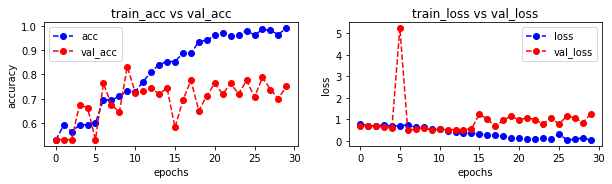

In [46]:
plot_accuracy_loss(history)

In [50]:
preds = model.predict(val_images) 

In [97]:
pred_ped = []

for i in preds:
    if i > .5:
        pred_ped.append(1)
    else:
        pred_ped.append(0)
    
    

In [98]:
pred_ped

[0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0]

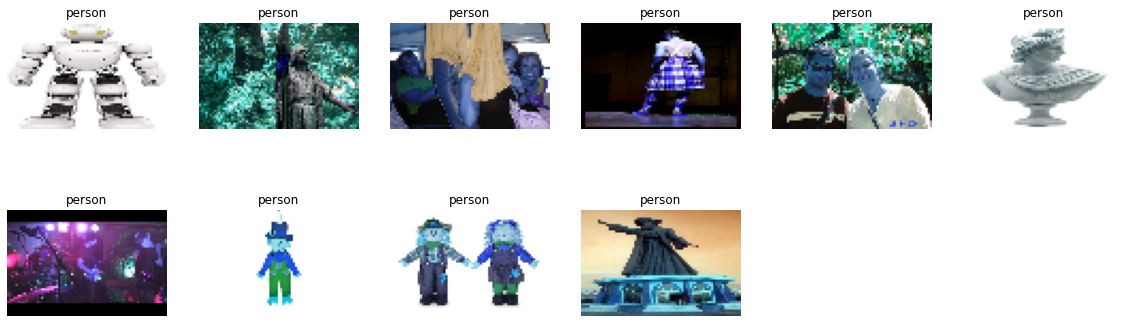

In [117]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(val_images),10))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(val_images[i])    
    plt.axis('off')
    x =np.argmax(pred_ped[0:2]) # takes the maximum of of the 6 probabilites. 
    plt.title((classes[x]))

In [118]:
confusion_matrix(val_labels,pred_ped)

array([[70, 15],
       [25, 50]], dtype=int64)

In [103]:
tn, fp, fn, tp = confusion_matrix(val_labels,pred_ped).ravel()

In [105]:
(tn, fp, fn, tp)

(70, 15, 25, 50)

In [125]:
# CNN model #2
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(5,5),strides=(1, 1),padding='same', activation='relu', input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=96, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=108, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])# specifically optimizing tp & fp want to detect all images correctly 


#saving off the model as an object for predicts etc...
history = model.fit(train_images, train_labels, epochs=30, batch_size=32,
                    validation_data=(val_images, val_labels))

Epoch 1/30
30/30 [==============================] - 96s 3s/step - loss: 5.3182 - accuracy: 0.5053 - val_loss: 0.6985 - val_accuracy: 0.5312
Epoch 2/30
30/30 [==============================] - 93s 3s/step - loss: 0.6934 - accuracy: 0.5540 - val_loss: 0.6963 - val_accuracy: 0.5312
Epoch 3/30
30/30 [==============================] - 95s 3s/step - loss: 0.7160 - accuracy: 0.5593 - val_loss: 0.6742 - val_accuracy: 0.5312
Epoch 4/30
30/30 [==============================] - 96s 3s/step - loss: 0.6954 - accuracy: 0.5731 - val_loss: 0.7306 - val_accuracy: 0.5312
Epoch 5/30
30/30 [==============================] - 99s 3s/step - loss: 0.7090 - accuracy: 0.5858 - val_loss: 0.6561 - val_accuracy: 0.5312
Epoch 6/30
30/30 [==============================] - 97s 3s/step - loss: 0.6787 - accuracy: 0.6144 - val_loss: 0.6181 - val_accuracy: 0.7563
Epoch 7/30
30/30 [==============================] - 93s 3s/step - loss: 0.6772 - accuracy: 0.6525 - val_loss: 0.6271 - val_accuracy: 0.5437
Epoch 8/30
30/30 [==

In [15]:
size = (100,80)

In [16]:
# loading in the data
(train_images_3, train_labels_3),(test_images_3, test_labels_3),(val_images_3, val_labels_3) = load_data()

In [17]:
train_images_3.shape

(944, 80, 100, 3)

In [18]:
# CNN model #3
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(5,5),strides=(1, 1),padding='same', activation='relu', input_shape=(80,100, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=96, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=108, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])# specifically optimizing tp & fp want to detect all images correctly 


#saving off the model as an object for predicts etc...
history = model.fit(train_images_3, train_labels_3, epochs=30, batch_size=32,
                    validation_data=(val_images_3, val_labels_3))

Epoch 1/30
30/30 [==============================] - 37s 1s/step - loss: 1.0889 - accuracy: 0.5339 - val_loss: 0.6825 - val_accuracy: 0.5688
Epoch 2/30
30/30 [==============================] - 36s 1s/step - loss: 0.7794 - accuracy: 0.6261 - val_loss: 0.6816 - val_accuracy: 0.5312
Epoch 3/30
30/30 [==============================] - 39s 1s/step - loss: 0.6812 - accuracy: 0.6059 - val_loss: 0.6686 - val_accuracy: 0.6438
Epoch 4/30
30/30 [==============================] - 37s 1s/step - loss: 0.6864 - accuracy: 0.6314 - val_loss: 0.6763 - val_accuracy: 0.5312
Epoch 5/30
30/30 [==============================] - 43s 1s/step - loss: 0.6542 - accuracy: 0.6356 - val_loss: 0.6102 - val_accuracy: 0.6125
Epoch 6/30
30/30 [==============================] - 37s 1s/step - loss: 0.6351 - accuracy: 0.6419 - val_loss: 0.6005 - val_accuracy: 0.7563
Epoch 7/30
30/30 [==============================] - 35s 1s/step - loss: 0.5961 - accuracy: 0.7373 - val_loss: 0.4957 - val_accuracy: 0.7625
Epoch 8/30
30/30 [==

In [19]:
size = (50,50)

In [20]:
# loading in the data
(train_images_4, train_labels_4),(test_images_4, test_labels_4),(val_images_4, val_labels_4) = load_data()

In [21]:
# create CNN model#4 
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(5,5),strides=(1, 1),padding='same', activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=96, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=108, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])# specifically optimizing tp & fp want to detect all images correctly 


#saving off the model as an object for predicts etc...
history = model.fit(train_images_4, train_labels_4, epochs=30, batch_size=32,
                    validation_data=(val_images_4, val_labels_4))

Epoch 1/30
30/30 [==============================] - 10s 350ms/step - loss: 0.7457 - accuracy: 0.5360 - val_loss: 0.6739 - val_accuracy: 0.5000
Epoch 2/30
30/30 [==============================] - 10s 343ms/step - loss: 0.6817 - accuracy: 0.5816 - val_loss: 0.6185 - val_accuracy: 0.6250
Epoch 3/30
30/30 [==============================] - 10s 347ms/step - loss: 0.7002 - accuracy: 0.6070 - val_loss: 0.6351 - val_accuracy: 0.6500
Epoch 4/30
30/30 [==============================] - 12s 385ms/step - loss: 0.6597 - accuracy: 0.6462 - val_loss: 0.6259 - val_accuracy: 0.6250
Epoch 5/30
30/30 [==============================] - 12s 397ms/step - loss: 0.6599 - accuracy: 0.6504 - val_loss: 0.6041 - val_accuracy: 0.6625
Epoch 6/30
30/30 [==============================] - 14s 482ms/step - loss: 0.6328 - accuracy: 0.6801 - val_loss: 0.6272 - val_accuracy: 0.6500
Epoch 7/30
30/30 [==============================] - 13s 445ms/step - loss: 0.5407 - accuracy: 0.7309 - val_loss: 0.7583 - val_accuracy: 0.6687